In [1]:
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime

In [2]:
tickers=pd.read_csv('tickers.csv')
tickers=tickers['ticker'].to_list()
data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)
for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker})
    data = pd.merge(data,d,on='Date')

In [3]:
cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week

/tmp/ipykernel_876/3635024390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['Datetime'] = pd.to_datetime(cal['Date'])
/tmp/ipykernel_876/3635024390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['year'] = cal['Datetime'].dt.year
/tmp/ipykernel_876/3635024390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [4]:
cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]

/tmp/ipykernel_876/501106492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal['mon'] = 1


In [5]:
data = data.set_index('Date')

In [7]:
R = data.pct_change()
R = R.fillna(0)
R = R + 1
R = R.cumprod()

In [8]:
Benchmark = pd.read_csv('sp500.csv')
Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
Benchmark = Benchmark.pct_change()
Benchmark = Benchmark.fillna(0)
Benchmark = Benchmark + 1
Benchmark = Benchmark.cumprod()

In [9]:
T = R.shape[0]
N = R.shape[1]


In [10]:
di = pd.DataFrame(index=Benchmark.index,columns=['Close'])

In [25]:
w = weight.value
d = R['2022-12-01':'2022-12-30'].values@w
d = np.expand_dims(d, 1)
di['2022-12-01':'2022-12-30']=d

In [26]:
dstart = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].min()

In [27]:
mon_window = 36
weight = cvx.Variable(N)
for i in range(120 - mon_window):
    start = i+1
    end = i+mon_window
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()
    asset = R[startdate:enddate].values
    indx = Benchmark[startdate:enddate].values
    indx = np.squeeze(indx)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= .0])
    mintracerr.solve(verbose=True)
    w = weight.value
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    d = R[dstart:dend].values@w
    d = np.expand_dims(d, 1)
    di[dstart:dend]=d

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Feb 20 12:43:47 PM: Your problem has 50 variables, 2 constraints, and 0 parameters.
(CVXPY) Feb 20 12:43:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 20 12:43:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 20 12:43:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 20 12:43:47 PM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 20 12:43:47 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

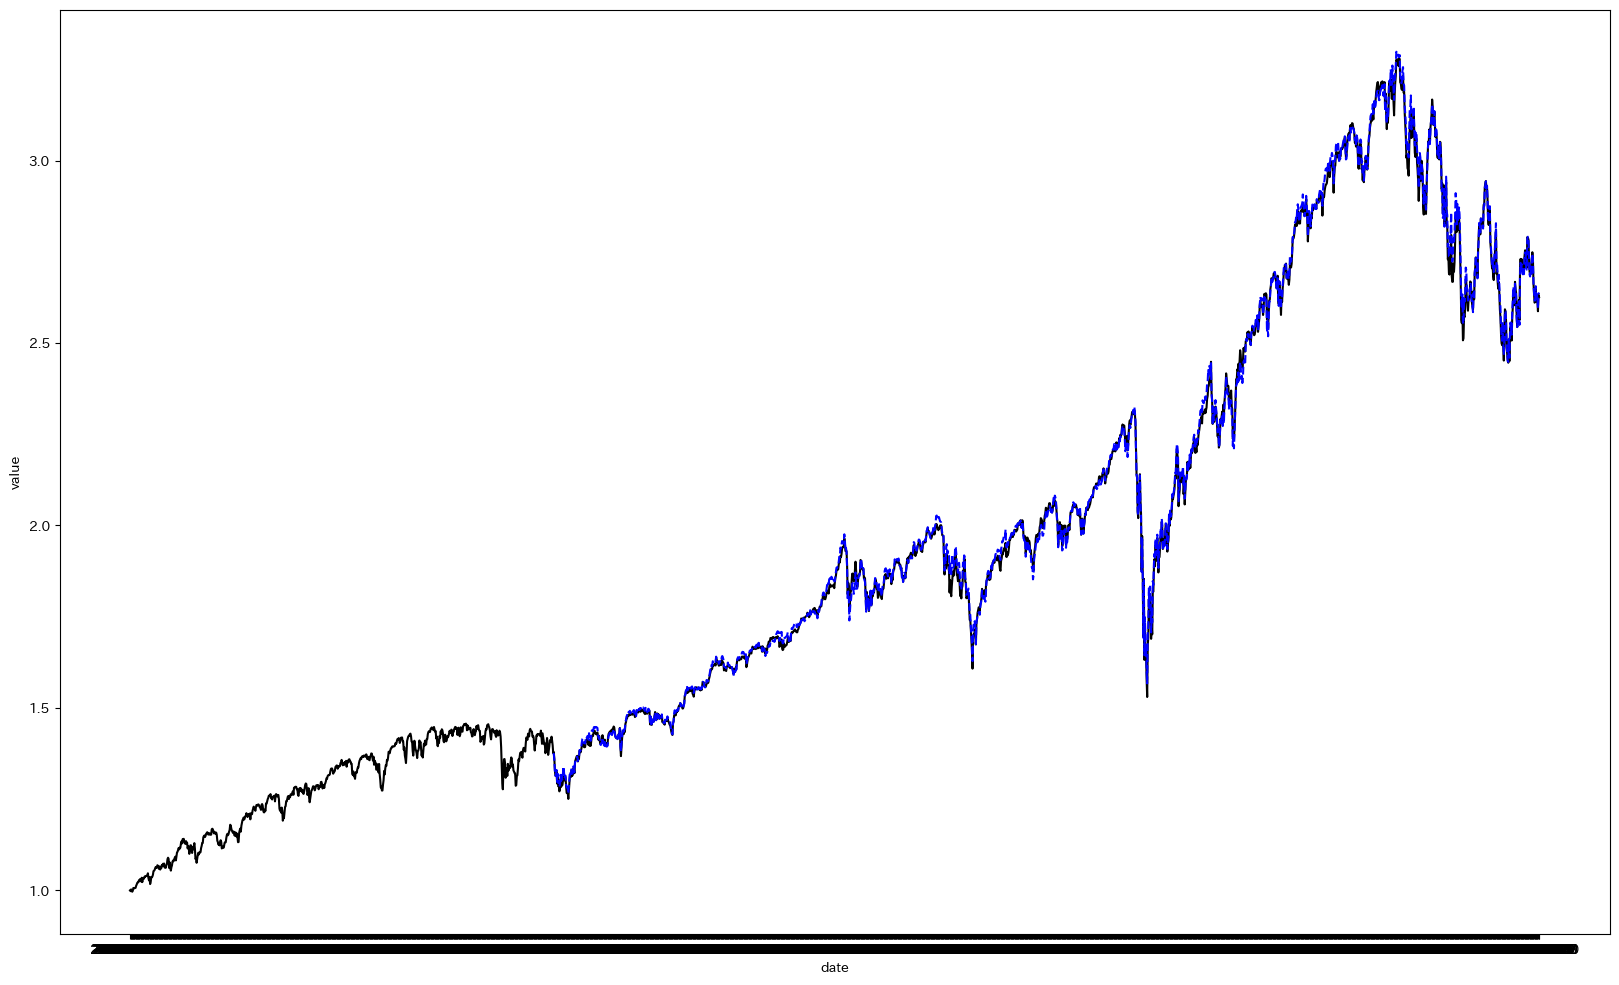

In [32]:
import japanize_matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, xlabel='date', ylabel='value')
ax.plot(Benchmark.index,Benchmark,c='k')
ax.plot(di.index,di,c='b',linestyle="--")